In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
%matplotlib inline

In [33]:
class TimeSeriesData():
    def __init__(self, num_points, xmin, xmax):
        
        self.min = xmin
        self.max = xmax
        self.num_points = num_points
        self.resolution = (xmax - xmin) / num_points
        self.x_data = np.linspace(start=xmin, stop=xmax, num=num_points)
        self.y_data = np.sin(self.x_data)
    
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        
        rand_start = np.random.rand(batch_size, 1)
        
        ts_start = rand_start * (self.max - self.min - self.resolution * steps)
        
        batch_ts = ts_start + np.arange(steps + 1) * self.resolution
        
        y_batch = np.sin(batch_ts)
        
        if (return_batch_ts):
            return y_batch[:, :-1].reshape(batch_size, steps, 1), y_batch[:,1:].reshape(batch_size, steps, 1), batch_ts
        else:
            return y_batch[:, :-1].reshape(batch_size, steps, 1), y_batch[:,1:].reshape(batch_size, steps, 1)
        


In [38]:
tf.reset_default_graph()

num_time_step = 30
num_inputs = 1
num_neurons = 100
num_output = 1
learning_rate = 0.001
num_train_iterations = 2000
batch_size = 1

# y placeholder (tensor)
y = tf.placeholder(tf.float32, [None, num_time_step, 1])
# x placeholder (tensor)
x = tf.placeholder(tf.float32, [None, num_time_step, 1])

cell = tf.contrib.rnn.OutputProjectionWrapper(
        tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
        output_size=num_output)

output, states = tf.nn.dynamic_rnn(cell=cell, inputs=x, dtype=tf.float32)

loss = tf.reduce_mean(tf.square(output - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)
saver = tf.train.Saver()

tsd = TimeSeriesData(xmin=-10, xmax=10, num_points=1000)

with tf.Session() as sess:
    sess.run(init)
    
    for i in range(num_train_iterations):
        x_batch, y_batch = tsd.next_batch(batch_size, num_time_step)
        
        sess.run(train, feed_dict = {x:x_batch, y:y_batch})
        
        if ((i % 100) == 0):
            
            mse = loss.eval(feed_dict={x: x_batch, y: y_batch})
            print (i, "\tMSE:", mse)
            
    saver.save(sess, "./RNN_Model")

0 	MSE: 0.0541992
100 	MSE: 0.0133054
200 	MSE: 0.00372103
300 	MSE: 0.0103516
400 	MSE: 0.00486993
500 	MSE: 9.28489e-05
600 	MSE: 0.000142341
700 	MSE: 7.74565e-05
800 	MSE: 8.24477e-05
900 	MSE: 0.00032884
1000 	MSE: 0.000139496
1100 	MSE: 0.000307636
1200 	MSE: 0.000230173
1300 	MSE: 0.000186161
1400 	MSE: 0.000146562
1500 	MSE: 0.000209765
1600 	MSE: 0.000141819
1700 	MSE: 0.000251
1800 	MSE: 0.000208074
1900 	MSE: 0.000172878


INFO:tensorflow:Restoring parameters from ./RNN_Model


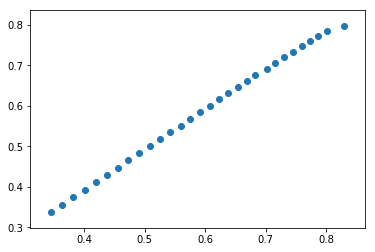

In [45]:
y_now, y_next = tsd.next_batch(batch_size=1,steps=num_time_step, return_batch_ts=False)
with tf.Session() as sess:
    saver.restore(sess, "./RNN_Model")
    
    y_pred = sess.run(output, feed_dict={x:y_now})

In [ ]:
data = TimeSeriesData(100, -10, 10)
y_now, y_next = data.next_batch(1, 10)